# 02 - Spending Allocation by State

Break down state + federal spending into categories and classify as **investment** or **cost**.

**Investment** (produces future economic returns):
- K-12 education
- Higher education
- Children's health programs (CHIP)
- Childcare / FMLA / state PFML programs
- Infrastructure / highways
- Public safety

**Cost** (necessary but purely consumptive):
- Social Security payments
- Elderly care / nursing facilities
- Medicaid (elderly portion)
- Pensions

**Data source:** Census Annual Survey of State Government Finances, SSA

**Output:** `spending_breakdown.csv`, `spending_breakdown.json`

In [1]:
import sys, os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

sys.path.insert(0, str(Path("..").resolve()))
from src.data_utils import (
    download_file, load_census_state_finances,
    fetch_ssa_oasdi_payments, fetch_state_population, _state_name_to_abbr,
)

load_dotenv(Path("../.env"))

RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

# Load state population data for per-capita calculations
population = fetch_state_population()
print(f"{len(population)} states with population data")

Using embedded Census 2023 population data
51 states with population data


In [2]:
INVESTMENT_CATEGORIES = [
    "education_k12",
    "education_higher",
    "children_health",
    "childcare_family_leave",
    "highways_infrastructure",
    "public_safety",
]

COST_CATEGORIES = [
    "social_security",
    "elderly_care",
    "medicaid_elderly",
    "pensions",
]

In [3]:
# Download Census Annual Survey of State Government Finances
# Try multiple known URLs for the expenditure-by-function table
FINANCE_URLS = [
    "https://www2.census.gov/programs-surveys/state/tables/2023/2023_STC_Detailed_Table.xlsx",
    "https://www2.census.gov/programs-surveys/state/tables/2022/2022_STC_Detailed_Table.xlsx",
    "https://www2.census.gov/programs-surveys/state/tables/2023/STC_Detailed_Table.xlsx",
]

finances = None
for url in FINANCE_URLS:
    try:
        finance_path = download_file(url, RAW_DIR / "state_finances.xlsx", force=True)
        finances = load_census_state_finances(finance_path)
        print(f"{len(finances)} rows, {finances['state'].nunique()} states")
        print("Sample categories:")
        print(finances["category"].unique()[:20])
        break
    except Exception as e:
        print(f"Could not fetch {url}: {e}")
        continue

if finances is None:
    print("\nCensus finance download unavailable — using tax-based spending estimates.")

Could not fetch https://www2.census.gov/programs-surveys/state/tables/2023/2023_STC_Detailed_Table.xlsx: 404 Client Error: Not Found for url: https://www2.census.gov/programs-surveys/state/tables/2023/2023_STC_Detailed_Table.xlsx


Could not fetch https://www2.census.gov/programs-surveys/state/tables/2022/2022_STC_Detailed_Table.xlsx: 404 Client Error: Not Found for url: https://www2.census.gov/programs-surveys/state/tables/2022/2022_STC_Detailed_Table.xlsx


Could not fetch https://www2.census.gov/programs-surveys/state/tables/2023/STC_Detailed_Table.xlsx: 404 Client Error: Not Found for url: https://www2.census.gov/programs-surveys/state/tables/2023/STC_Detailed_Table.xlsx

Census finance download unavailable — using tax-based spending estimates.


In [4]:
# Fetch SSA OASDI benefit payments by state
ssa = fetch_ssa_oasdi_payments()
print(f"{len(ssa)} states with SSA data")
ssa.head()

Using embedded SSA OASDI data (fallback)
51 states with SSA data


,state,state_name,total_benefits
0,AL,Alabama,14063.0
1,AK,Alaska,1394.0
2,AZ,Arizona,17892.0
3,AR,Arkansas,8784.0
4,CA,California,78670.0


In [5]:
# Map spending categories to investment vs cost
# Census state finance categories (keywords to match)
INVESTMENT_KEYWORDS = [
    "education", "school", "higher ed", "elementary", "secondary",
    "health", "hospital", "highway", "road", "transit",
    "police", "fire", "correction", "protective",
    "parks", "recreation", "natural resources", "environment",
]
COST_KEYWORDS = [
    "welfare", "public welfare", "pension", "retirement",
    "insurance trust", "unemployment comp", "worker",
]

def classify_spending(category: str) -> str:
    """Classify a spending category as 'investment', 'cost', or 'other'."""
    cat_lower = category.lower()
    for kw in INVESTMENT_KEYWORDS:
        if kw in cat_lower:
            return "investment"
    for kw in COST_KEYWORDS:
        if kw in cat_lower:
            return "cost"
    return "other"

def fmt_thousands(x):
    """Format value in thousands of $ to human-readable."""
    if abs(x) >= 1e6:
        return f"${x/1e6:,.1f}B"
    if abs(x) >= 1e3:
        return f"${x/1e3:,.1f}M"
    return f"${x:,.0f}K"

if finances is not None:
    finances["class"] = finances["category"].apply(classify_spending)
    print("Classification distribution:")
    print(finances.groupby("class")["amount"].sum())

    # Aggregate by state
    spending_by_state = (
        finances.groupby(["state", "state_name", "class"])["amount"]
        .sum()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Ensure columns exist
    for col in ["investment", "cost", "other"]:
        if col not in spending_by_state.columns:
            spending_by_state[col] = 0.0

    spending_by_state["investment_spending"] = spending_by_state["investment"]
    spending_by_state["cost_spending"] = spending_by_state["cost"]
else:
    # Fallback: estimate state spending using per-state investment share ratios
    # derived from Census Annual Survey of State Government Finances averages.
    STATE_INVESTMENT_SHARE = {
        "AL": 0.58, "AK": 0.52, "AZ": 0.55, "AR": 0.59, "CA": 0.50,
        "CO": 0.56, "CT": 0.46, "DE": 0.54, "FL": 0.57, "GA": 0.58,
        "HI": 0.53, "ID": 0.61, "IL": 0.48, "IN": 0.57, "IA": 0.59,
        "KS": 0.58, "KY": 0.56, "LA": 0.55, "ME": 0.54, "MD": 0.52,
        "MA": 0.49, "MI": 0.53, "MN": 0.54, "MS": 0.60, "MO": 0.56,
        "MT": 0.59, "NE": 0.60, "NV": 0.55, "NH": 0.57, "NJ": 0.48,
        "NM": 0.57, "NY": 0.47, "NC": 0.58, "ND": 0.62, "OH": 0.54,
        "OK": 0.57, "OR": 0.53, "PA": 0.50, "RI": 0.50, "SC": 0.57,
        "SD": 0.61, "TN": 0.58, "TX": 0.57, "UT": 0.63, "VT": 0.55,
        "VA": 0.56, "WA": 0.54, "WV": 0.56, "WI": 0.55, "WY": 0.60,
        "DC": 0.45,
    }
    print("Using embedded state investment share estimates (fallback)")
    tax_burden = pd.read_csv(PROCESSED_DIR / "tax_burden.csv")
    spending_by_state = tax_burden[["state", "state_name", "total_state_taxes"]].copy()
    spending_by_state["inv_share"] = spending_by_state["state"].map(STATE_INVESTMENT_SHARE).fillna(0.55)
    spending_by_state["investment_spending"] = spending_by_state["total_state_taxes"] * spending_by_state["inv_share"]
    spending_by_state["cost_spending"] = spending_by_state["total_state_taxes"] * (1 - spending_by_state["inv_share"])

# Add SSA payments as a cost category (convert millions to thousands to match tax data units)
ssa_merged = ssa[["state", "total_benefits"]].copy()
ssa_merged["social_security"] = ssa_merged["total_benefits"] * 1000  # millions -> thousands
spending_by_state = spending_by_state.merge(ssa_merged[["state", "social_security"]], on="state", how="left")
spending_by_state["social_security"] = spending_by_state["social_security"].fillna(0)

# Add social security to cost spending
spending_by_state["cost_spending"] = (
    spending_by_state["cost_spending"] + spending_by_state["social_security"]
)

# Calculate totals and investment ratio
spending_by_state["total_spending"] = (
    spending_by_state["investment_spending"] + spending_by_state["cost_spending"]
)
spending_by_state["investment_ratio"] = (
    spending_by_state["investment_spending"] / spending_by_state["total_spending"]
)

# Add per-capita spending (amounts are in thousands of $)
spending_by_state = spending_by_state.merge(population[["state", "population"]], on="state", how="left")
spending_by_state["total_per_capita"] = (spending_by_state["total_spending"] * 1000) / spending_by_state["population"]
spending_by_state["investment_per_capita"] = (spending_by_state["investment_spending"] * 1000) / spending_by_state["population"]
spending_by_state["cost_per_capita"] = (spending_by_state["cost_spending"] * 1000) / spending_by_state["population"]

print(f"\nStates: {len(spending_by_state)}")
print(f"Investment ratio range: {spending_by_state['investment_ratio'].min():.1%} – "
      f"{spending_by_state['investment_ratio'].max():.1%}")
print(f"Mean investment ratio: {spending_by_state['investment_ratio'].mean():.1%}")
print(f"Per-capita total spending range: ${spending_by_state['total_per_capita'].min():,.0f} – "
      f"${spending_by_state['total_per_capita'].max():,.0f}")

# Display with readable units
display_df = spending_by_state[["state", "state_name", "investment_per_capita",
                                 "cost_per_capita", "total_per_capita", "investment_ratio"]].copy()
display_df["investment_per_capita"] = display_df["investment_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df["cost_per_capita"] = display_df["cost_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df["total_per_capita"] = display_df["total_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df["investment_ratio"] = spending_by_state["investment_ratio"].apply(lambda x: f"{x:.1%}")
display_df.sort_values("state_name").head(10)

Using embedded state investment share estimates (fallback)



States: 48
Investment ratio range: 27.8% – 47.7%
Mean investment ratio: 34.8%
Per-capita total spending range: $4,658 – $9,920


,state,state_name,investment_per_capita,cost_per_capita,total_per_capita,investment_ratio
0,AL,Alabama,"$1,918","$4,142","$6,060",31.7%
2,AZ,Arizona,"$1,746","$3,836","$5,583",31.3%
1,AR,Arkansas,"$2,438","$4,557","$6,995",34.8%
3,CA,California,"$3,408","$5,427","$8,834",38.6%
4,CO,Colorado,"$1,760","$3,452","$5,212",33.8%
5,CT,Connecticut,"$2,952","$6,061","$9,013",32.8%
6,DE,Delaware,"$3,420","$5,513","$8,933",38.3%
7,FL,Florida,"$1,590","$3,796","$5,386",29.5%
8,GA,Georgia,"$1,769","$3,397","$5,167",34.2%
10,ID,Idaho,"$2,587","$4,064","$6,651",38.9%


In [6]:
# Export to CSV and JSON
export_cols = [
    "state", "state_name", "investment_spending", "cost_spending",
    "total_spending", "investment_ratio", "population",
    "investment_per_capita", "cost_per_capita", "total_per_capita",
]
out = spending_by_state[export_cols].sort_values("state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "spending_breakdown.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "spending_breakdown.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

Wrote ../data/processed/spending_breakdown.csv
Wrote ../docs/charts/data/spending_breakdown.json


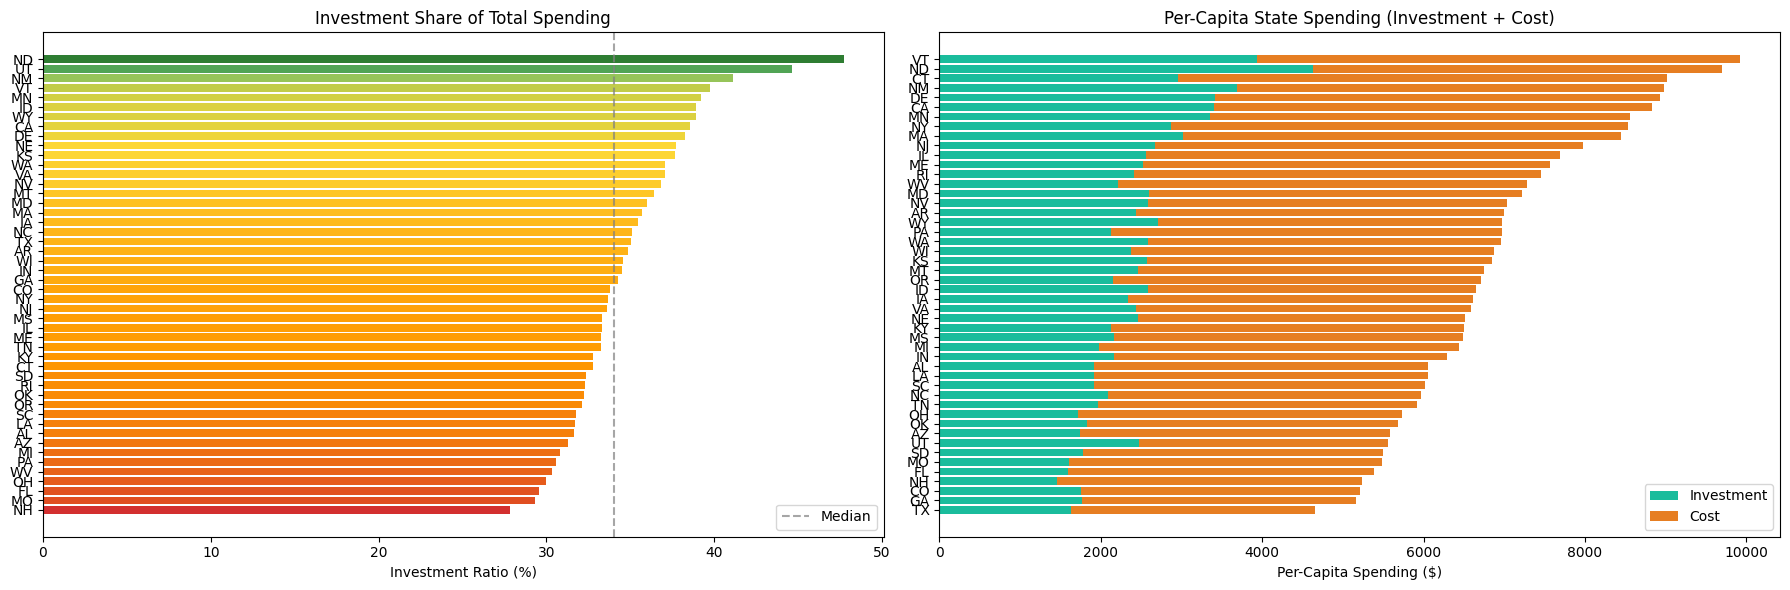

In [7]:
# Visualization — Per-capita spending by state
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: Investment ratio
ax1 = axes[0]
plot_data = out.sort_values("investment_ratio", ascending=True)
norm = (plot_data["investment_ratio"] - plot_data["investment_ratio"].min()) / \
       (plot_data["investment_ratio"].max() - plot_data["investment_ratio"].min())
colors = SCORE_CMAP(norm)
ax1.barh(plot_data["state"], plot_data["investment_ratio"] * 100, color=colors)
ax1.set_xlabel("Investment Ratio (%)")
ax1.set_title("Investment Share of Total Spending")
ax1.axvline(x=plot_data["investment_ratio"].median() * 100,
           color="gray", linestyle="--", alpha=0.7, label="Median")
ax1.legend(["Median"])

# Right: Per-capita total spending (stacked investment + cost)
ax2 = axes[1]
plot_data2 = out.sort_values("total_per_capita", ascending=True)
ax2.barh(plot_data2["state"], plot_data2["investment_per_capita"], color="#1abc9c", label="Investment")
ax2.barh(plot_data2["state"], plot_data2["cost_per_capita"],
         left=plot_data2["investment_per_capita"], color="#e67e22", label="Cost")
ax2.set_xlabel("Per-Capita Spending ($)")
ax2.set_title("Per-Capita State Spending (Investment + Cost)")
ax2.legend()

plt.tight_layout()
plt.show()

In [8]:
import plotly.express as px

# Green = high (good), Red = low — custom scale
SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = px.choropleth(
    out,
    locations="state",
    locationmode="USA-states",
    color="investment_ratio",
    color_continuous_scale=SCORE_SCALE,
    scope="usa",
    hover_name="state_name",
    hover_data={
        "state": False,
        "investment_ratio": ":.1%",
        "investment_per_capita": ":$,.0f",
        "cost_per_capita": ":$,.0f",
        "total_per_capita": ":$,.0f",
        "investment_spending": False,
        "cost_spending": False,
        "total_spending": False,
        "population": ":,.0f",
    },
    labels={
        "investment_ratio": "Investment Ratio",
        "investment_per_capita": "Investment/Capita",
        "cost_per_capita": "Cost/Capita",
        "total_per_capita": "Total/Capita",
        "population": "Population",
    },
    title="Spending Allocation — Investment Ratio (Per-Capita)",
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Inv. Ratio", tickformat=".0%"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()

In [9]:
# Subcategory maps — Per-Capita Investment & Cost Spending
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
    subplot_titles=["Investment Spending Per Capita", "Cost Spending Per Capita"],
)

for i, (col, title) in enumerate([
    ("investment_per_capita", "Investment"),
    ("cost_per_capita", "Cost"),
], start=1):
    hover_text = [
        f"{name}<br>{title}/Capita: ${v:,.0f}"
        for name, v in zip(out["state_name"], out[col])
    ]
    fig.add_trace(go.Choropleth(
        locations=out["state"],
        z=out[col],
        locationmode="USA-states",
        colorscale=SCORE_SCALE,
        colorbar=dict(title=f"$/Capita", x=0.45 if i == 1 else 1.0),
        hovertext=hover_text,
        hovertemplate="%{hovertext}<extra></extra>",
    ), row=1, col=i)

fig.update_geos(scope="usa", lakecolor="rgb(255,255,255)")
fig.update_layout(title_text="Per-Capita Spending by Category", height=450)
fig.show()